# Movie Recommendation System with MovieLens Data



## Overview

This notebook walks through the end-to-end steps for building a simple movie
recommendation system using the MovieLens ratings dataset:

- Part 1: Data wrangling and feature engineering
- Part 2: Exploratory data analysis (EDA)
- Part 3: Building a basic recommendation model

Along the way, we inspect data quality, explore rating behavior, and finally
use user rating patterns to recommend movies similar to a chosen title.

In [2]:
#importing all necessary libraries
import pandas as pd
import seaborn as sns

## Part 1: Data Wrangling & Engineering

In this section, we load the raw MovieLens data, merge the movies and ratings
tables, and create summary statistics that will be used later by the
recommendation system.

In [4]:
#load data in csv
movies_data = pd.read_csv('movies.csv')
ratings_data = pd.read_csv('ratings.csv')

In [17]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [15]:
ratings_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### 1.1 Merging Movies and Ratings

Here we join the `movies` and `ratings` tables on `movieId` to create a single
dataframe that contains, for each rating:
- the user who rated it (`userId`),
- the movie title and genres, and
- the numeric rating and timestamp.

This merged dataframe (`df`) is the core dataset for the rest of the analysis.

In [21]:
df = pd.merge(movies_data, ratings_data, on='movieId')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


### 1.2 Main Analysis Dataframe

`df` is our main working dataframe. It includes:

- `userId`: the user who provided the rating,
- `movieId` and `title`: which movie was rated,
- `genres`: one or more genres for the movie,
- `rating` and `timestamp`: the rating value and when it was given.

We will use this combined information to compute statistics and eventually
build the recommendation system.

### 1.3 Data Quality Checks

Before modeling, we quickly check for missing values and duplicates to ensure
the dataset is clean and suitable for analysis.

In [29]:
df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [30]:
df.duplicated().value_counts()

False    100836
Name: count, dtype: int64

The results show that there are no missing values and no duplicated rows,
which means we can proceed without additional cleaning steps.

In [44]:
# Average rating and rating count
movie_stats = df.groupby('title')['rating'].agg(['mean', 'count']) # getting the average rating and how many rated the movie using groupby function
movie_stats.rename(columns={'mean': 'ave_rating', 'count': 'rating_count'}, inplace=True) #renaming columns
movie_stats.head()

,ave_rating,rating_count
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


### 1.4 Movie-Level Rating Statistics

Next, we compute two key statistics for each movie:

- `ave_rating`: the average rating across all users,
- `rating_count`: how many users have rated the movie.

To focus on movies with reliable estimates, we filter to those with at least
50 ratings. This avoids recommending movies that look good only because they
were rated by a very small number of users.

In [53]:
movie_stats_filtered = movie_stats['rating_count'] >= 50
popular_movies = movie_stats[movie_stats['rating_count'] >= 50]
popular_movies.head()
# We successfully filtered movies that have 50 or more ratings

,ave_rating,rating_count
title,,
10 Things I Hate About You (1999),3.527778,54
12 Angry Men (1957),4.149123,57
2001: A Space Odyssey (1968),3.894495,109
28 Days Later (2002),3.974138,58
300 (2007),3.681250,80


In [59]:
final_df = pd.merge(df, popular_movies, on='title', how='inner')
# we used inner join because we only want to preserve the intersections between the two dataframes.
final_df.head()
final_df.unique()


,movieId,title,genres,userId,rating,timestamp,ave_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,3.92093,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,3.92093,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,3.92093,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,3.92093,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,3.92093,215


### 1.5 Movie-Level Summary Dataframe

We also create a simplified movie-level dataframe (`movie_df`) by removing
columns related to individual ratings (`userId`, `rating`, `timestamp`) and
dropping duplicates.

This leaves one row per movie, containing its title, genres, average rating,
and rating count—useful for high-level summaries and reporting.

In [73]:
movie_df = final_df.drop(columns=['userId', 'rating', 'timestamp']) #dropped columns
movie_df.drop_duplicates(inplace=True) # dropped the duplicates
movie_df.head()

,movieId,title,genres,ave_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,215
215,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,110
325,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,52
377,6,Heat (1995),Action|Crime|Thriller,3.946078,102
479,7,Sabrina (1995),Comedy|Romance,3.185185,54


## Part 2: Exploratory Data Analysis

In this section, we explore how users rate movies overall, how popularity
relates to rating quality, and which genres receive the most ratings.

### 2.1 How Generous Are Users?

We first look at the distribution of rating values to understand how strict
or generous users tend to be when scoring movies.

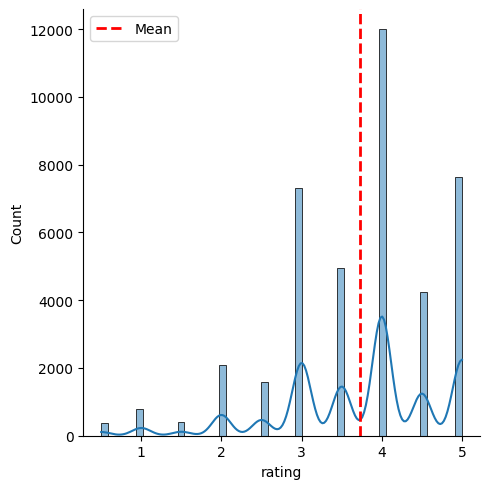

In [80]:
g = sns.displot(final_df['rating'], kde=True)
g.ax.axvline(final_df['rating'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
g.ax.legend()

This plot shows how ratings are distributed across all movies. The dashed
vertical line marks the mean rating (around 3.7), suggesting that users are
generally moderately positive but still discriminating in their scores.

### 2.2 Popularity vs. Rating

Next, we investigate whether more popular movies (those with many ratings)
also tend to receive higher average ratings.

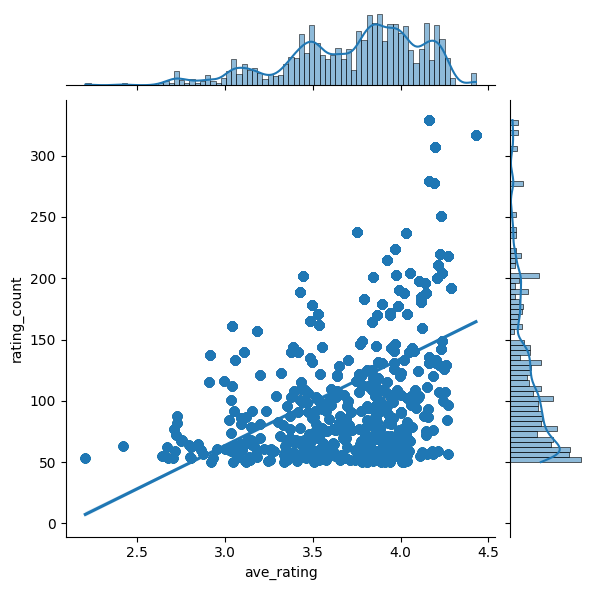

In [83]:
sns.jointplot(x='ave_rating', y='rating_count', data=final_df, kind='reg')

The joint plot shows a positive relationship between rating count and average
rating: movies with more ratings are often rated slightly higher. This may
reflect that widely watched movies are either higher quality or more
polarizing, but in this dataset the trend is generally upward.

### 2.3 Most Rated Genres

Finally, we break out the `genres` column, count how often each genre appears
in the ratings, and visualize the top 10 most frequently rated genres.

This reveals which types of movies users in this dataset engage with the most.

C:\Users\Louis\AppData\Local\Temp\ipykernel_4156\3435855689.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


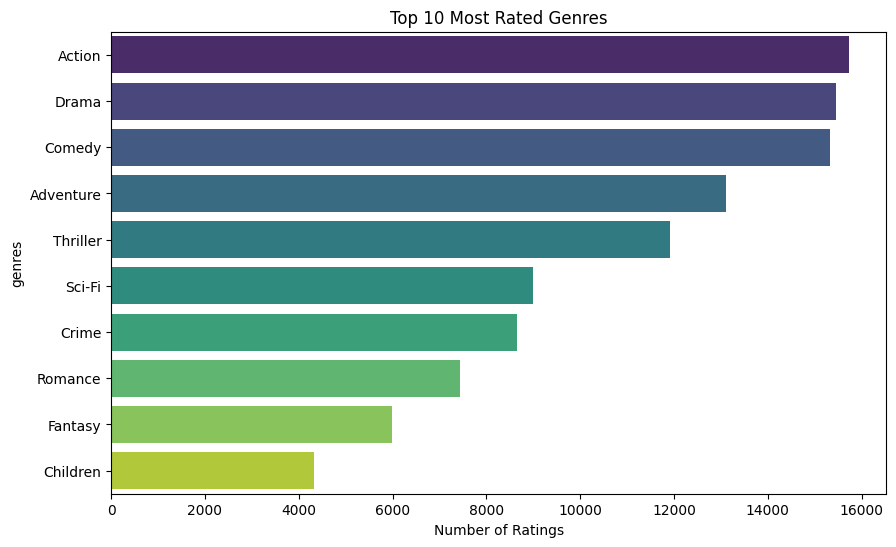

In [86]:
import matplotlib.pyplot as plt
# create a temporary data frame
genre_df = final_df.copy()
# split genre strings
genre_df['genres'] = genre_df['genres'].str.split('|')
# explode the list to separate each genre
genre_exploded = genre_df.explode('genres')
# count the top 10 genres
top_genres = genre_exploded['genres'].value_counts().head(10)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 10 Most Rated Genres')
plt.xlabel('Number of Ratings')
plt.show()

## Part 3: Recommendation System


In this section, we build a simple item-based collaborative filtering recommendation system.
We use historical user ratings to find movies that are most similar to a chosen title based on
how users rated them.

In [89]:
# We will make a matrix of userId and title and their ratings using pivot tables
matrix = final_df.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,5.0,5.0,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN
4,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1 User–Movie Rating Matrix


Using the code above, we create a pivot table (matrix) where:


- Each row represents a `userId`.
- Each column represents a movie `title`.
- Each cell contains the rating that user gave to that movie.



This matrix allows us to compare rating patterns across movies and is the foundation for
finding movies that are most similar to a given film (in this case, *Toy Story (1995)*).

In [96]:

target_movie = 'Toy Story (1995)'
target_ratings = matrix[target_movie]

# calculate Correlation

similar_to_target = matrix.corrwith(target_ratings)

# clean up the results
corr_target = pd.DataFrame(similar_to_target, columns=['Correlation'])
corr_target.dropna(inplace=True)

# merge with rating_count
corr_target = corr_target.join(movie_stats['rating_count'])

# 5. Filter and Sort
recommendations = corr_target[corr_target['rating_count'] > 50].sort_values('Correlation', ascending=False)
recommendations.head(10)

,Correlation,rating_count
title,,
Toy Story (1995),1.000000,215
Toy Story 2 (1999),0.699211,97
Arachnophobia (1990),0.652424,53
"Incredibles, The (2004)",0.643301,125
Finding Nemo (2003),0.618701,141
Aladdin (1992),0.611892,183
Erin Brockovich (2000),0.598016,70
Wallace & Gromit: The Wrong Trousers (1993),0.589625,56
Blazing Saddles (1974),0.585892,62


### 3.2 Recommendations for *Toy Story (1995)*


The table above shows movies that are most correlated with *Toy Story (1995)* based on user
rating patterns:

- We compute the correlation between *Toy Story (1995)* and every other movie using the rating matrix.
- We keep only movies with at least 50 ratings to avoid noisy, rarely rated titles.
- We then sort by correlation to see the strongest similarities.



*Toy Story (1995)* has a correlation of 1.0 with itself by definition. The other highly correlated
movies are mostly family-friendly animated or adventure titles (often from Disney/Pixar), which makes
intuitive sense as good recommendations for someone who enjoyed *Toy Story (1995)*.

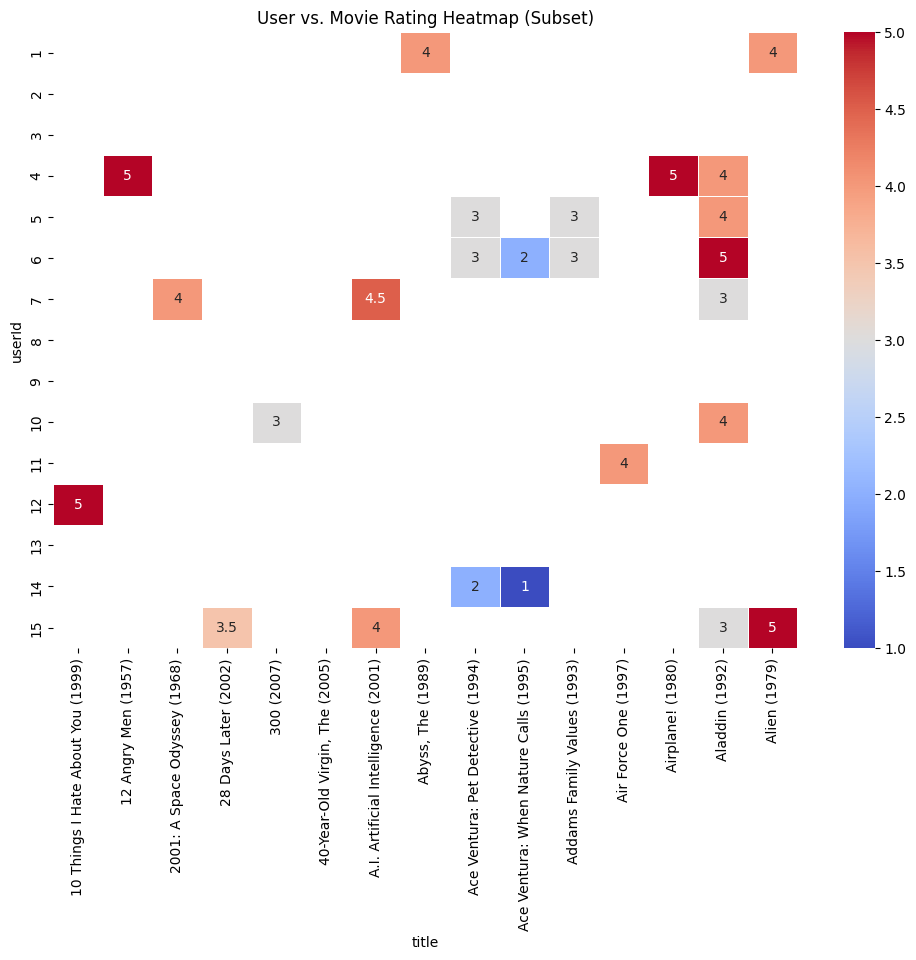

In [95]:
# Here I just want to display User Vs Movie Rating Heatmap of the first 15 users
# This allows you to visually spot "clusters" of users who like the same things.
subset_matrix = matrix.iloc[:15, :15]


plt.figure(figsize=(12, 8))
sns.heatmap(subset_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('User vs. Movie Rating Heatmap')
plt.show()